# Ключевые метрики для оценки алгостратегий

## 1. Доходность
Доходность - это мера прибыльности стратегии, показывающая, насколько увеличился капитал за определенный период. Существует несколько видов доходности:

## 2. Дродаун (Drawdown)
Дродаун - это показатель риска, который измеряет максимальное снижение стоимости портфеля от предыдущего пика до последующей низшей точки. Он помогает оценить:

Получение данных BTCUSDT с 01.01.2023 по 10.05.2025...
Период анализа: 01.01.2023 - 10.05.2025
Общая доходность: 524.36%
Годовая доходность (CAGR): 117.57%
Максимальная просадка: -32.31%
Индекс восстановления: 16.23


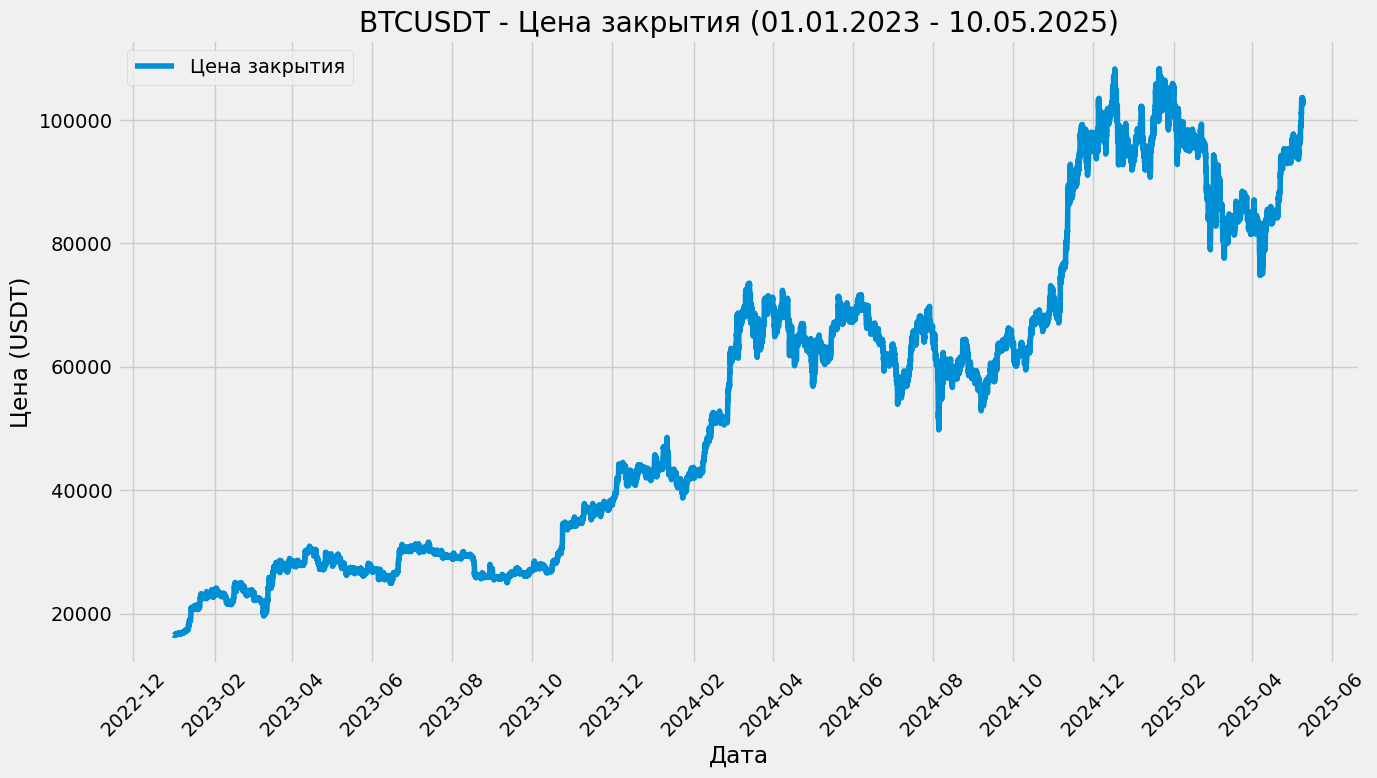

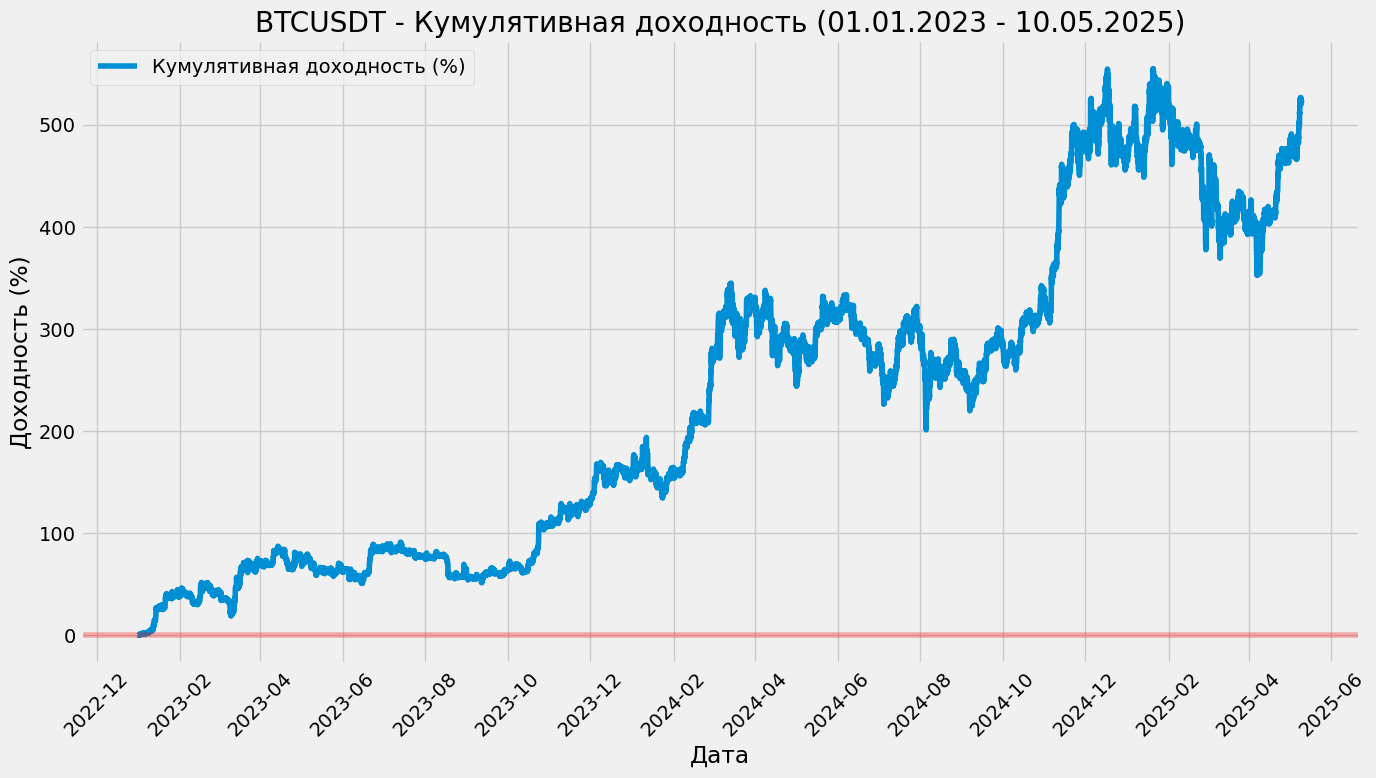

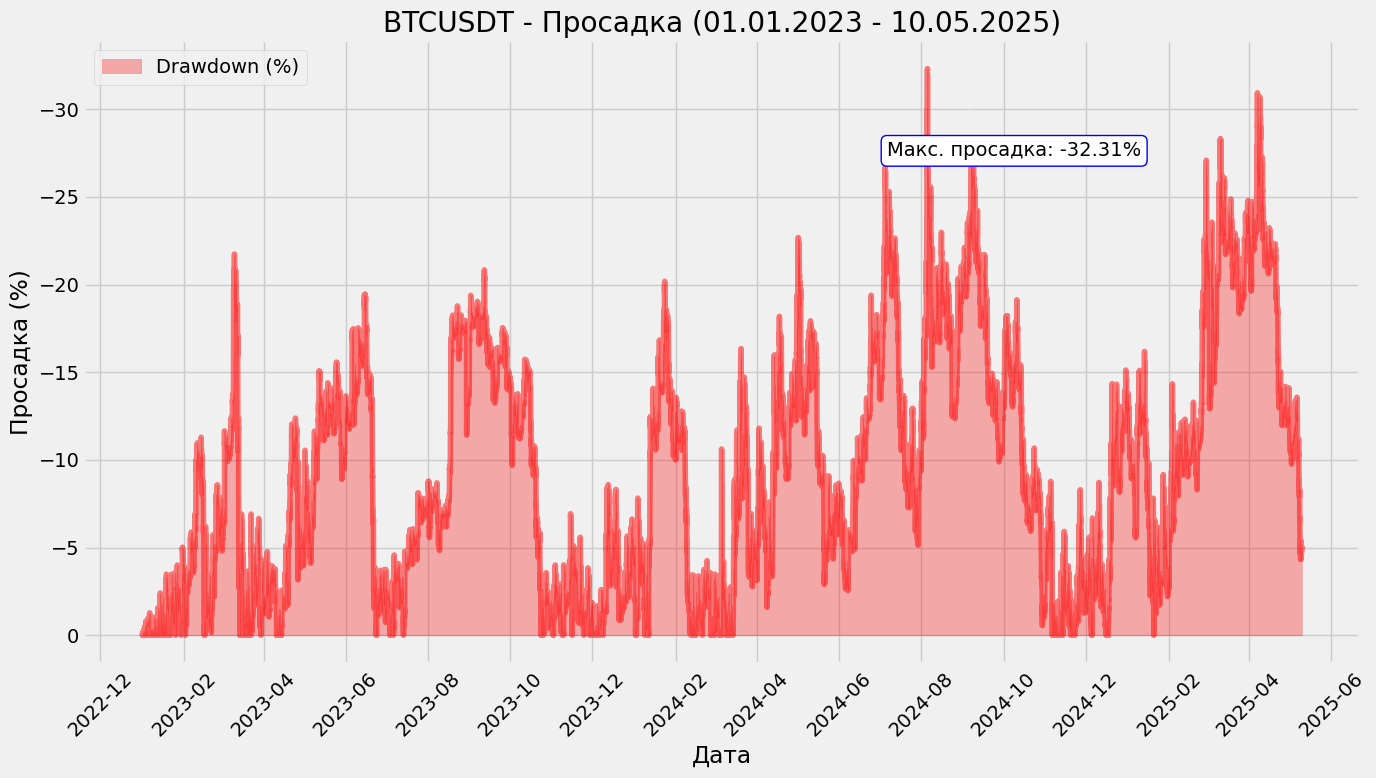

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
from datetime import datetime, timedelta
import time

# Установка стиля для графиков
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 8)

def get_binance_klines(symbol, interval, start_time, end_time):
    """Получение исторических данных с Binance"""
    url = "https://api.binance.com/api/v3/klines"
    
    # Преобразование дат в миллисекунды (временная метка Unix)
    start_ts = int(datetime.strptime(start_time, "%d.%m.%Y").timestamp() * 1000)
    end_ts = int(datetime.strptime(end_time, "%d.%m.%Y").timestamp() * 1000)
    
    # Параметры запроса
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ts,
        'endTime': end_ts,
        'limit': 1000
    }
    
    all_klines = []
    
    # Binance имеет ограничение на количество свечей в одном запросе,
    # поэтому мы используем цикл для получения всех данных
    current_start = start_ts
    
    while current_start < end_ts:
        params['startTime'] = current_start
        response = requests.get(url, params=params)
        klines = response.json()
        
        if not klines:
            break
        
        all_klines.extend(klines)
        
        # Обновление времени начала для следующей итерации
        current_start = klines[-1][0] + 1
        
        # Задержка, чтобы не превысить лимиты API
        time.sleep(0.1)
    
    # Преобразование данных в DataFrame
    df = pd.DataFrame(all_klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    # Преобразование типов данных
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = df[col].astype(float)
    
    # Установка timestamp в качестве индекса
    df.set_index('timestamp', inplace=True)
    
    return df

def calculate_returns(df):
    """Расчет доходности"""
    # Вычисление процентного изменения цены закрытия
    df['daily_return'] = df['close'].pct_change()
    
    # Вычисление кумулятивной доходности
    df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
    
    return df

def calculate_drawdown(df):
    """Расчет просадки (drawdown)"""
    # Расчет пикового значения до текущего момента
    df['peak'] = df['close'].cummax()
    
    # Расчет drawdown
    df['drawdown'] = (df['close'] - df['peak']) / df['peak']
    
    return df

def plot_price(df, title):
    """Визуализация цены"""
    fig, ax = plt.subplots()
    ax.plot(df.index, df['close'], label='Цена закрытия')
    
    # Форматирование графика
    ax.set_title(title)
    ax.set_xlabel('Дата')
    ax.set_ylabel('Цена (USDT)')
    ax.legend()
    ax.grid(True)
    
    # Форматирование оси X для лучшего отображения дат
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_returns(df, title):
    """Визуализация доходности"""
    fig, ax = plt.subplots()
    ax.plot(df.index, df['cumulative_return'] * 100, label='Кумулятивная доходность (%)')
    
    # Форматирование графика
    ax.set_title(title)
    ax.set_xlabel('Дата')
    ax.set_ylabel('Доходность (%)')
    ax.legend()
    ax.grid(True)
    
    # Форматирование оси X для лучшего отображения дат
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Добавление горизонтальной линии на уровне 0
    ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_drawdown(df, title):
    """Визуализация просадки (drawdown)"""
    fig, ax = plt.subplots()
    ax.fill_between(df.index, df['drawdown'] * 100, 0, color='red', alpha=0.3, label='Drawdown (%)')
    ax.plot(df.index, df['drawdown'] * 100, color='red', alpha=0.5)
    
    # Найти максимальную просадку
    max_dd = df['drawdown'].min() * 100
    max_dd_date = df['drawdown'].idxmin()
    
    # Добавить аннотацию о максимальной просадке
    ax.annotate(f'Макс. просадка: {max_dd:.2f}%', 
                xy=(max_dd_date, max_dd),
                xytext=(max_dd_date - timedelta(days=30), max_dd + 5),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=1))
    
    # Форматирование графика
    ax.set_title(title)
    ax.set_xlabel('Дата')
    ax.set_ylabel('Просадка (%)')
    ax.legend()
    ax.grid(True)
    
    # Форматирование оси X для лучшего отображения дат
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Инвертирование оси Y для более наглядного отображения просадки
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def print_strategy_metrics(df):
    """Вывод основных метрик стратегии"""
    # Рассчитываем общую доходность
    total_return = df['cumulative_return'].iloc[-1] * 100
    
    # Рассчитываем годовую доходность (CAGR)
    days = (df.index[-1] - df.index[0]).days
    annual_return = ((1 + df['cumulative_return'].iloc[-1]) ** (365 / days) - 1) * 100
    
    # Максимальная просадка
    max_drawdown = df['drawdown'].min() * 100
    
    # Индекс восстановления (доходность / макс. просадка)
    recovery_index = abs(total_return / max_drawdown) if max_drawdown != 0 else float('inf')
    
    # Выводим результаты
    print(f"Период анализа: {df.index[0].strftime('%d.%m.%Y')} - {df.index[-1].strftime('%d.%m.%Y')}")
    print(f"Общая доходность: {total_return:.2f}%")
    print(f"Годовая доходность (CAGR): {annual_return:.2f}%")
    print(f"Максимальная просадка: {max_drawdown:.2f}%")
    print(f"Индекс восстановления: {recovery_index:.2f}")

# Основная функция
def main():
    # Параметры для получения данных
    symbol = "BTCUSDT"
    interval = "1h"  # 1 час
    start_date = "01.01.2023"
    end_date = "10.05.2025"
    
    # Получение данных
    print(f"Получение данных {symbol} с {start_date} по {end_date}...")
    df = get_binance_klines(symbol, interval, start_date, end_date)
    
    # Расчет метрик
    df = calculate_returns(df)
    df = calculate_drawdown(df)
    
    # Вывод метрик
    print_strategy_metrics(df)
    
    # Визуализация
    plot_price(df, f"{symbol} - Цена закрытия ({start_date} - {end_date})")
    plot_returns(df, f"{symbol} - Кумулятивная доходность ({start_date} - {end_date})")
    plot_drawdown(df, f"{symbol} - Просадка ({start_date} - {end_date})")

if __name__ == "__main__":
    main()

# Виды доходностей
* ## Абсолютная доходность (Absolute Return)
Описание: Показывает общую прибыль/убыток в денежном выражении
Формула:
$AR = Конечная стоимость - Начальная стоимость$

Оценка: Используется для быстрой оценки результата в абсолютных величинах, но не учитывает размер инвестиций

* ## Относительная доходность (Simple Return)
Описание: Процентное изменение капитала за период.
Формула:
$RR = (Конечная стоимость - Начальная стоимость) / Начальная стоимость × 100%$

Оценка: Простая оценка эффективности, позволяет сравнивать инвестиции разного размера
* ## Логарифмическая доходность (Log Return)
Описание: Натуральный логарифм отношения конечной стоимости к начальной
Формула:
$LR = ln(Конечная стоимость / Начальная стоимость)$

Оценка: Имеет лучшие статистические свойства, удобна для сложения по периодам, часто используется в финансовом моделировании
* ## Годовая доходность (Annualized Return)
Описание: Доходность, приведенная к годовому периоду
Формула:
$AR = ((1 + RR)^(365/t) - 1) × 100%$, где 

t - продолжительность периода в днях
Оценка: Позволяет сравнивать доходность стратегий за разные периоды времени
* ## CAGR (Compound Annual Growth Rate)
Описание: Среднегодовой темп роста с учетом сложного процента.
Формула:
$CAGR = ((Конечная стоимость / Начальная стоимость)^(1/n) - 1) × 100%$, где n - число лет

Оценка: Сглаживает колебания, показывая постоянную ставку роста за весь период

* ## TWR (Time-Weighted Return)
Описание: Доходность, учитывающая временную стоимость денег без учета влияния внешних денежных потоков
Формула:
$TWR = ((1+R₁) × (1+R₂) × ... × (1+Rₙ)) - 1$, где Rᵢ - доходность за субпериод i

Оценка: Используется для оценки эффективности управления капиталом, исключая влияние пополнений и изъятий
* ## MWR (Money-Weighted Return) или IRR (Internal Rate of Return)
Описание: Учитывает размеры и время денежных потоков.
Формула: Ставка r, при которой NPV = 0:
$NPV = ∑(CFᵢ / (1+r)^i) = 0$, где CFᵢ - денежный поток в период i

Оценка: Оценивает фактический результат для инвестора с учетом всех вводов и выводов капитала
* ## Excess Return (Alpha)
Описание: Доходность сверх бенчмарка (например, индекса рынка).
Формула:
$α = Доходность стратегии - Доходность бенчмарка$

Оценка: Ключевой показатель для активно управляемых стратегий, показывает добавленную стоимость

# Виды drawdown
* ## Абсолютный drawdown (Absolute Drawdown)
Описание: Разница между начальным капиталом и текущим минимумом.
Формула:
$AD = Начальный капитал - Минимальный капитал$

Оценка: Оценивает максимальное снижение относительно первоначального капитала.
* ## Максимальный drawdown (Maximum Drawdown, MDD)
Описание: Максимальное процентное снижение от предыдущего пика до последующей впадины.
Формула:
$MDD = min(0, min_t((V(t) - peak(t)) / peak(t))) × 100%$, где:

* V(t) - стоимость в момент времени t
* peak(t) - максимальная стоимость до момента t

Оценка: Ключевой показатель риска для инвесторов, отражает наихудший сценарий потерь.
* ## Относительный drawdown (Relative Drawdown)
Описание: Процентное снижение от пика до впадины.
Формула:
$RD = (Пиковое значение - Минимальное значение) / Пиковое значение × 100%$

Оценка: Используется для сравнения рисков различных стратегий.
* ## Средний drawdown (Average Drawdown)
Описание: Среднее значение всех drawdown за период.
Формула:
$AvgDD = (∑DD_i) / n$, где DD_i - i-й drawdown, n - количество drawdown

Оценка: Оценивает типичную глубину просадок стратегии.
* ## Условный drawdown (Conditional Drawdown, CDaR)
Описание: Среднее значение наихудших drawdown, превышающих определенный порог (например, VaR).
Формула:
$CDaR(α) = E[DD | DD > VaR(α)]$, где α - доверительный уровень

Оценка: Улучшенная оценка риска, учитывающая "хвосты" распределения

# Коэффициент Шарпа (Sharpe Ratio)

Коэффициент Шарпа (Sharpe Ratio) -  измеряет избыточную доходность на единицу риска

Формула коэффициента Шарпа:

$Sharpe Ratio = (Rp - Rf) / σp$, 

* Rp - средняя доходность портфеля или стратегии
* Rf - безрисковая ставка доходности (например, доходность государственных облигаций)
* σp - стандартное отклонение доходности портфеля (мера риска)

Коэффициент Шарпа оценивает избыточную доходность на единицу общего риска (волатильности).

* Плюсы: Широко используется, простой для понимания
* Минусы: Штрафует за положительную волатильность, предполагает нормальное распределение доходностей

Шарп: Для общей оценки соотношения доходность/риск в стратегиях с примерно симметричным распределением доходностей

Получение данных BTCUSDT с 01.01.2023 по 01.05.2025...
=== Метрики SMA стратегии ===
Период анализа: 01.01.2023 - 01.05.2025

--- Доходность ---
Общая доходность стратегии: -68.87%
Общая доходность BTCUSDT: 473.29%
Средняя доходность стратегии (за период): -0.005045%
Средняя доходность BTCUSDT (за период): 0.009917%

--- Риск ---
Стандартное отклонение доходности стратегии (волатильность): 0.365809%
Стандартное отклонение доходности BTCUSDT (волатильность): 0.522686%

--- Коэффициент Шарпа ---
Коэффициент Шарпа стратегии (годовой): -0.5469
Коэффициент Шарпа BTCUSDT (годовой): 0.1642

--- Интерпретация коэффициента Шарпа ---
Стратегия: Отрицательный коэффициент Шарпа - стратегия работает хуже безрисковой ставки
Стратегия работает ХУЖЕ, чем простое удержание BTCUSDT (отстает на 0.7110)


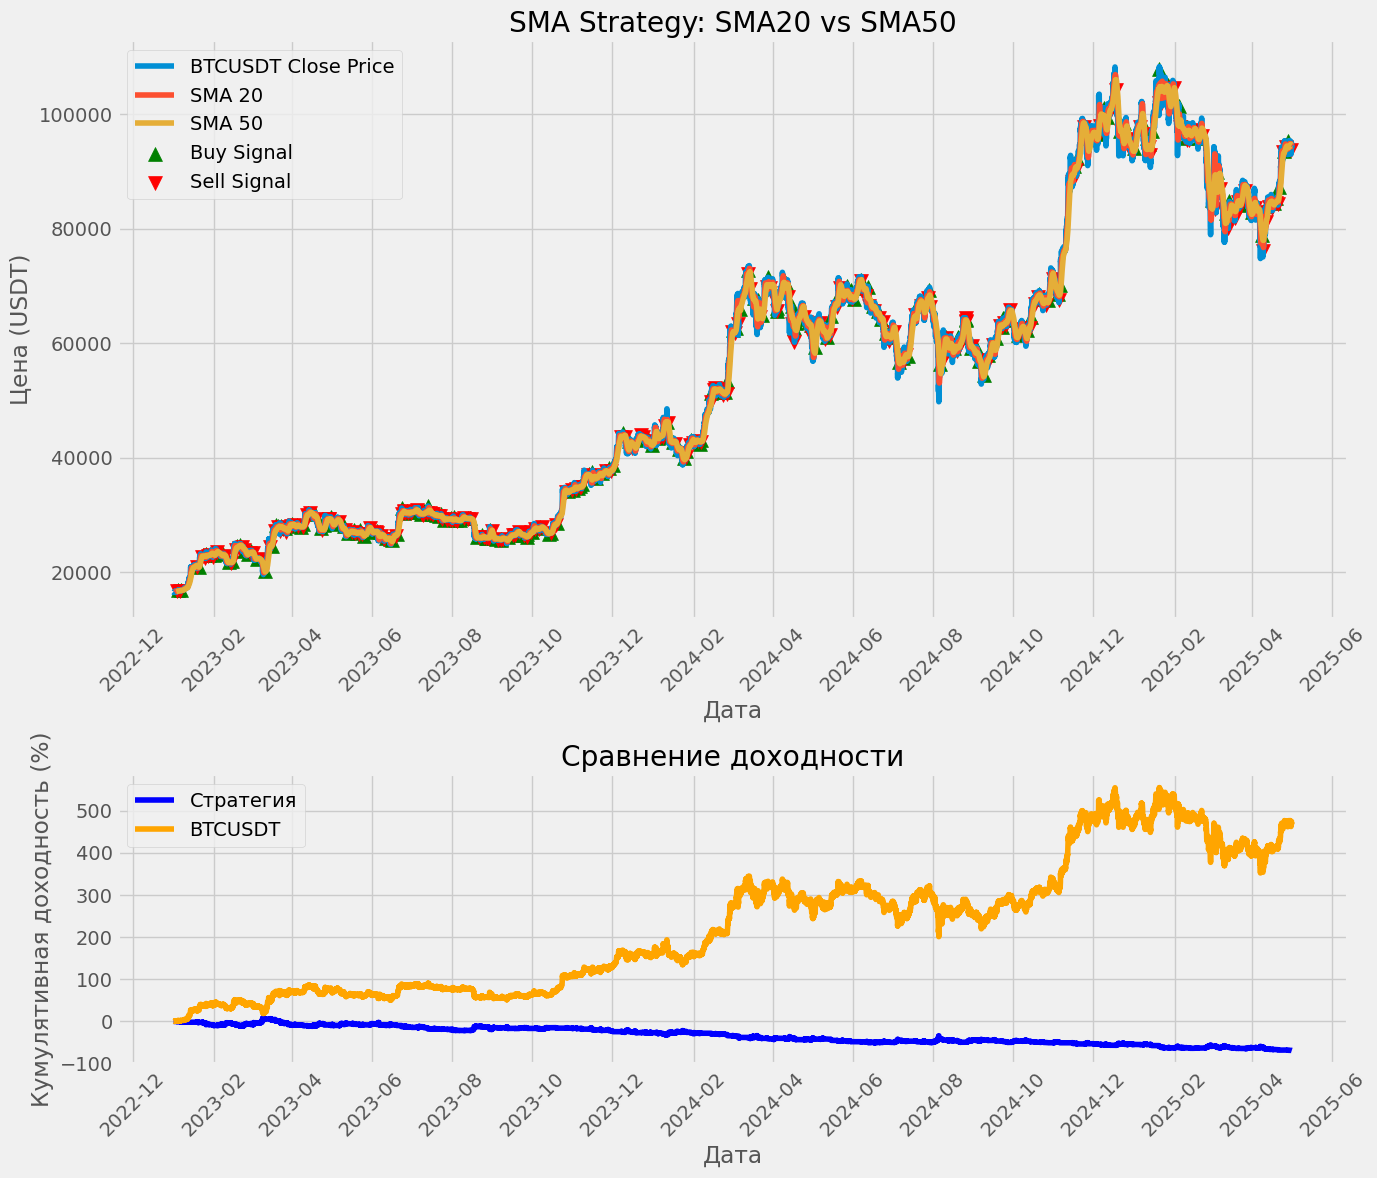

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
from datetime import datetime, timedelta
import time

# Установка стиля для графиков
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 8)

def get_binance_klines(symbol, interval, start_time, end_time):
    """Получение исторических данных с Binance"""
    url = "https://api.binance.com/api/v3/klines"
    
    # Преобразование дат в миллисекунды (временная метка Unix)
    start_ts = int(datetime.strptime(start_time, "%d.%m.%Y").timestamp() * 1000)
    end_ts = int(datetime.strptime(end_time, "%d.%m.%Y").timestamp() * 1000)
    
    # Параметры запроса
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ts,
        'endTime': end_ts,
        'limit': 1000
    }
    
    all_klines = []
    
    # Binance имеет ограничение на количество свечей в одном запросе,
    # поэтому мы используем цикл для получения всех данных
    current_start = start_ts
    
    while current_start < end_ts:
        params['startTime'] = current_start
        response = requests.get(url, params=params)
        klines = response.json()
        
        if not klines:
            break
        
        all_klines.extend(klines)
        
        # Обновление времени начала для следующей итерации
        current_start = klines[-1][0] + 1
        
        # Задержка, чтобы не превысить лимиты API
        time.sleep(0.1)
    
    # Преобразование данных в DataFrame
    df = pd.DataFrame(all_klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    # Преобразование типов данных
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = df[col].astype(float)
    
    # Установка timestamp в качестве индекса
    df.set_index('timestamp', inplace=True)
    
    return df

def implement_sma_strategy(df, short_window, long_window):
    """Реализация стратегии на основе пересечения двух SMA"""
    # Создание копии DataFrame
    df_strategy = df.copy()
    
    # Вычисление скользящих средних
    df_strategy['sma_short'] = df_strategy['close'].rolling(window=short_window).mean()
    df_strategy['sma_long'] = df_strategy['close'].rolling(window=long_window).mean()
    
    # Создание сигналов
    df_strategy['signal'] = 0
    # Сигнал 1: когда короткая SMA пересекает длинную SMA снизу вверх
    df_strategy['signal'] = np.where(
        (df_strategy['sma_short'] > df_strategy['sma_long']) & 
        (df_strategy['sma_short'].shift(1) <= df_strategy['sma_long'].shift(1)), 
        1, df_strategy['signal']
    )
    # Сигнал -1: когда короткая SMA пересекает длинную SMA сверху вниз
    df_strategy['signal'] = np.where(
        (df_strategy['sma_short'] < df_strategy['sma_long']) & 
        (df_strategy['sma_short'].shift(1) >= df_strategy['sma_long'].shift(1)), 
        -1, df_strategy['signal']
    )
    
    # Создание позиций (1: длинная позиция, 0: нет позиции, -1: короткая позиция)
    df_strategy['position'] = df_strategy['signal'].cumsum()
    
    # Ограничение позиций от -1 до 1 (если мы не используем леверидж)
    df_strategy['position'] = df_strategy['position'].clip(-1, 1)
    
    # Расчет доходности стратегии
    df_strategy['strategy_return'] = df_strategy['position'].shift(1) * df_strategy['close'].pct_change()
    
    # Расчет кумулятивной доходности стратегии
    df_strategy['cumulative_strategy_return'] = (1 + df_strategy['strategy_return']).cumprod() - 1
    
    # Расчет доходности BTCUSDT (базовая доходность)
    df_strategy['btcusdt_return'] = df_strategy['close'].pct_change()
    df_strategy['cumulative_btcusdt_return'] = (1 + df_strategy['btcusdt_return']).cumprod() - 1
    
    return df_strategy

def plot_sma_strategy(df_strategy, short_window, long_window):
    """Визуализация стратегии SMA"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})
    
    # График цены и SMA
    ax1.plot(df_strategy.index, df_strategy['close'], label='BTCUSDT Close Price')
    ax1.plot(df_strategy.index, df_strategy['sma_short'], label=f'SMA {short_window}')
    ax1.plot(df_strategy.index, df_strategy['sma_long'], label=f'SMA {long_window}')
    
    # Отметка сигналов на покупку и продажу
    buy_signals = df_strategy[df_strategy['signal'] == 1].index
    sell_signals = df_strategy[df_strategy['signal'] == -1].index
    
    ax1.scatter(buy_signals, df_strategy.loc[buy_signals, 'close'], marker='^', color='green', s=100, label='Buy Signal')
    ax1.scatter(sell_signals, df_strategy.loc[sell_signals, 'close'], marker='v', color='red', s=100, label='Sell Signal')
    
    ax1.set_title(f'SMA Strategy: SMA{short_window} vs SMA{long_window}')
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Цена (USDT)')
    ax1.legend()
    ax1.grid(True)
    
    # Форматирование оси X для лучшего отображения дат
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.get_xticklabels(), rotation=45)
    
    # График доходности
    ax2.plot(df_strategy.index, df_strategy['cumulative_strategy_return'] * 100, label='Стратегия', color='blue')
    ax2.plot(df_strategy.index, df_strategy['cumulative_btcusdt_return'] * 100, label='BTCUSDT', color='orange')
    
    ax2.set_title('Сравнение доходности')
    ax2.set_xlabel('Дата')
    ax2.set_ylabel('Кумулятивная доходность (%)')
    ax2.legend()
    ax2.grid(True)
    
    # Форматирование оси X для лучшего отображения дат
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=365):
    """
    Расчет коэффициента Шарпа
    
    Параметры:
    returns -- серия доходностей стратегии
    risk_free_rate -- безрисковая ставка (годовая)
    periods_per_year -- количество периодов в году (365 для дневных данных)
    
    Возвращает:
    sharpe_ratio -- коэффициент Шарпа (годовой)
    """
    # Удаляем NaN значения
    returns = returns.dropna()
    
    # Шаг 1: Рассчитываем среднюю доходность
    mean_return = returns.mean()
    
    # Шаг 2: Рассчитываем стандартное отклонение доходности (волатильность)
    std_return = returns.std()
    
    # Шаг 3: Переводим безрисковую ставку в ставку за период
    rf_per_period = (1 + risk_free_rate) ** (1 / periods_per_year) - 1
    
    # Шаг 4: Рассчитываем избыточную доходность
    excess_return = mean_return - rf_per_period
    
    # Шаг 5: Рассчитываем дневной коэффициент Шарпа
    daily_sharpe = excess_return / std_return if std_return != 0 else 0
    
    # Шаг 6: Рассчитываем годовой коэффициент Шарпа
    annual_sharpe = daily_sharpe * (periods_per_year ** 0.5)
    
    return annual_sharpe, mean_return, std_return

def print_strategy_metrics(df_strategy):
    """Вывод метрик стратегии"""
    # Расчет метрик для стратегии
    sharpe_ratio_strategy, mean_return_strategy, std_return_strategy = calculate_sharpe_ratio(
        df_strategy['strategy_return'],
        risk_free_rate=0.02,
        periods_per_year=365
    )
    
    # Расчет метрик для BTCUSDT
    sharpe_ratio_btc, mean_return_btc, std_return_btc = calculate_sharpe_ratio(
        df_strategy['btcusdt_return'],
        risk_free_rate=0.02,
        periods_per_year=365
    )
    
    # Общая доходность
    total_return_strategy = df_strategy['cumulative_strategy_return'].iloc[-1] * 100
    total_return_btc = df_strategy['cumulative_btcusdt_return'].iloc[-1] * 100
    
    # Вывод результатов
    print("=== Метрики SMA стратегии ===")
    print(f"Период анализа: {df_strategy.index[0].strftime('%d.%m.%Y')} - {df_strategy.index[-1].strftime('%d.%m.%Y')}")
    print("\n--- Доходность ---")
    print(f"Общая доходность стратегии: {total_return_strategy:.2f}%")
    print(f"Общая доходность BTCUSDT: {total_return_btc:.2f}%")
    print(f"Средняя доходность стратегии (за период): {mean_return_strategy*100:.6f}%")
    print(f"Средняя доходность BTCUSDT (за период): {mean_return_btc*100:.6f}%")
    
    print("\n--- Риск ---")
    print(f"Стандартное отклонение доходности стратегии (волатильность): {std_return_strategy*100:.6f}%")
    print(f"Стандартное отклонение доходности BTCUSDT (волатильность): {std_return_btc*100:.6f}%")
    
    print("\n--- Коэффициент Шарпа ---")
    print(f"Коэффициент Шарпа стратегии (годовой): {sharpe_ratio_strategy:.4f}")
    print(f"Коэффициент Шарпа BTCUSDT (годовой): {sharpe_ratio_btc:.4f}")
    
    # Выводим интерпретацию коэффициента Шарпа
    print("\n--- Интерпретация коэффициента Шарпа ---")
    if sharpe_ratio_strategy < 0:
        print("Стратегия: Отрицательный коэффициент Шарпа - стратегия работает хуже безрисковой ставки")
    elif sharpe_ratio_strategy < 0.5:
        print("Стратегия: Низкий коэффициент Шарпа - плохое соотношение риск/доходность")
    elif sharpe_ratio_strategy < 1:
        print("Стратегия: Ниже среднего - некоторое вознаграждение за риск")
    elif sharpe_ratio_strategy < 2:
        print("Стратегия: Хороший коэффициент Шарпа - приемлемое соотношение риск/доходность")
    else:
        print("Стратегия: Отличный коэффициент Шарпа - очень хорошее соотношение риск/доходность")
    
    # Сравнение со стратегией Buy & Hold (BTCUSDT)
    if sharpe_ratio_strategy > sharpe_ratio_btc:
        print(f"Стратегия работает ЛУЧШЕ, чем простое удержание BTCUSDT (превосходит на {sharpe_ratio_strategy - sharpe_ratio_btc:.4f})")
    else:
        print(f"Стратегия работает ХУЖЕ, чем простое удержание BTCUSDT (отстает на {sharpe_ratio_btc - sharpe_ratio_strategy:.4f})")

def main():
    # Параметры для получения данных
    symbol = "BTCUSDT"
    interval = "1h"  # 1 час
    start_date = "01.01.2023"
    end_date = "01.05.2025"  # Используем текущую дату
    
    # Параметры SMA стратегии
    short_window = 20  # 20-часовая SMA
    long_window = 50   # 50-часовая SMA
    
    # Получение данных
    print(f"Получение данных {symbol} с {start_date} по {end_date}...")
    df = get_binance_klines(symbol, interval, start_date, end_date)
    
    # Реализация стратегии
    df_strategy = implement_sma_strategy(df, short_window, long_window)
    
    # Вывод метрик
    print_strategy_metrics(df_strategy)
    
    # Визуализация стратегии
    plot_sma_strategy(df_strategy, short_window, long_window)

if __name__ == "__main__":
    main()

## 1. Стратегия на основе пересечения двух SMA
Создадим стратегию, которая:

Использует два простых скользящих средних (быстрое и медленное)
Генерирует сигнал на покупку, когда быстрое SMA пересекает медленное SMA снизу вверх
Генерирует сигнал на продажу, когда быстрое SMA пересекает медленное SMA сверху вниз

## 2. Расчет коэффициента Шарпа
Теперь разберем процесс расчета коэффициента Шарпа более подробно:
Формула коэффициента Шарпа:
$Sharpe Ratio = (Rₚ - Rᶠ) / σₚ$, где:

* Rₚ - средняя доходность стратегии (портфеля)
* Rᶠ - безрисковая ставка
* σₚ - стандартное отклонение доходности (волатильность)

### Шаги расчета:
1. Расчет средней доходности стратегии:
mean_return = returns.mean()
Этот шаг вычисляет среднее арифметическое всех доходностей за период. Формула:
* R̄ = (R₁ + R₂ + ... + Rₙ) / n*

2. Расчет стандартного отклонения доходности (волатильность)
   std_return = returns.std()
   Стандартное отклонение измеряет разброс доходностей относительно среднего значения. Формула:
   $σ = √[(R₁ - R̄)² + (R₂ - R̄)² + ... + (Rₙ - R̄)²) / n]$

3. Перевод годовой безрисковой ставки в ставку за период:
* rf_per_period = (1 + risk_free_rate) ** (1 / periods_per_year) - 1$

Эта формула переводит годовую ставку в часовую (или дневную, в зависимости от интервала данных)

4. Расчет избыточной доходности:
   
$excess_return = mean_return - rf_per_period$

Избыточная доходность показывает, насколько средняя доходность стратегии превосходит безрисковую ставку.

5. Расчет коэффициента Шарпа за период:
   
$daily_sharpe = excess_return / std_return$


Этот показатель измеряет избыточную доходность на единицу риска.

6. Перевод коэффициента Шарпа в годовое значение:

$annual_sharpe = daily_sharpe * (periods_per_year ** 0.5)$

Стандартная практика - приводить коэффициент Шарпа к годовому значению для сравнимости


#### В формуле annual_sharpe = daily_sharpe * (periods_per_year ** 0.5) выражение periods_per_year ** 0.5 означает квадратный корень из количества периодов в году.

#### В нашем примере periods_per_year = 365 (так как мы используем часовые данные, и в функции calculate_sharpe_ratio параметр установлен как 365), поэтому:
* Это значение 0.5 в степени (т.е. ** 0.5) представляет собой операцию извлечения квадратного корня. 0.5 здесь является показателем степени для операции извлечения квадратного корня, что является стандартной практикой при аннуализации финансовых показателей, основанных на волатильности.

# Коэффициент Сортино (Sortino Ratio)

$Sortino = (Rₚ - Rᶠ) / σᵈ$, где:

* Rₚ - средняя доходность стратегии (портфеля)
* Rᶠ - безрисковая ставка
* σᵈ - стандартное отклонение отрицательных доходностей (даунсайд-риск)

### Зачем нужен:
Коэффициент Сортино — это модификация коэффициента Шарпа, которая фокусируется только на негативной волатильности. В отличие от коэффициента Шарпа, который штрафует и за положительные, и за отрицательные колебания, коэффициент Сортино штрафует только за отрицательные отклонения

#### Коэффициент Сортино оценивает избыточную доходность на единицу негативного риска (даунсайд-риска).

* Плюсы: Не штрафует за положительные отклонения, лучше для асимметричных распределений
* Минусы: Требует выбора целевой доходности, сложнее для интерпретации

Сортино: Для стратегий с асимметричным распределением доходностей или когда инвесторов волнует только риск потерь

# Коэффициент Кальмара (Calmar Ratio)
$Формула: Calmar = CAGR / |MDD|$, где:

* CAGR - среднегодовой темп роста с учетом сложного процента
* MDD - максимальный дродаун (в десятичной форме)

### Зачем нужен:
Коэффициент Кальмара измеряет соотношение среднегодовой доходности к максимальной просадке. Он особенно полезен для оценки стратегий с точки зрения наихудшего сценария потерь. Высокий коэффициент Кальмара указывает на хорошее соотношение доходности и риска (в терминах просадки, а не волатильности).

#### Коэффициент Кальмара оценивает соотношение средней годовой доходности к максимальной просадке.

* Плюсы: Фокусируется на максимальных потерях, интуитивно понятен для инвесторов
* Минусы: Зависит от длины периода наблюдения, может быть нестабильным

Кальмар: Для стратегий с акцентом на управление просадками или когда максимальные потери критически важны

# T-тест (t-Statistic)
$t-stat = (X̄ - μ₀) / (σ / √n)$, где:

* X̄ - среднее значение выборки (средняя доходность)
* μ₀ - ожидаемое значение (часто 0, или безрисковая ставка)
* σ - стандартное отклонение выборки
* n - размер выборки (количество наблюдений)

### Зачем нужен:
T-тест используется для определения статистической значимости доходности стратегии. Он проверяет, отличается ли наблюдаемая средняя доходность статистически значимо от нуля (или от безрисковой ставки). Чем выше значение t-statistic, тем более статистически значимы результаты. Это важно для оценки того, является ли доходность стратегии результатом вашей удачи или все таки прямых рук

#### T-статистика оценивает статистическую значимость избыточной доходности.

* Плюсы: Проверяет статистическую достоверность результатов
* Минусы: Требует определенных предположений о распределении, не учитывает риск напрямую

T-статистика: Для проверки, является ли наблюдаемая доходность статистически значимой, особенно при небольшом количестве наблюдений.

In [2]:
from IPython.display import Image

Image(url='https://www.stellabooks.com/storage/images/stock/1820/1820618.JPG')
